In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell

nthreads = 2


In [2]:
include("../aux_functions.jl")
include("../inidat_aux_functions.jl")

f_x_max (generic function with 1 method)

In [3]:
undamped_l = false
undamped_s = false
damped = false
vlasov_exp_200 = false
vlasov_exp_40 = false
#undamped_s = true
damped = true
#vlasov_exp_40 = true
#vlasov_exp_200 = true

true

In [29]:
run_name = "norel_norm_"
data_name = "par_dis_landau_norm_norel_"
if undamped_l
    const L = 39.738 
    const J = 3522
    nm = 2 # this is defined again in inidat lambda = L/nm = 19.869
    #nm = 20
    data_name = data_name * "undamped_l_$(nm)_"
    run_name = run_name * "undamped_rel_"
elseif undamped_s
    const L = 4
    const J = 80
    nm = 2 # this is defined again in inidat lambda = L/nm = 2 which gives a k approx 0.1
    #nm = 20
    data_name = data_name * "undamped_s_$(nm)_"
    run_name = run_name * "undamped_rel_"
elseif damped
    const L = 7.455
    const J = 930
    nm = 15 # this is defined again in inidat lambda = L/nm = 0.497
    data_name = data_name * "damped_$(nm)_"
    run_name = run_name * "damped_rel_"
elseif vlasov_exp_200
    const L = 200
    const J = 2000
    #const nm = 10 # para comparar con 40_2 
    const nm = 2 # this is defined again in inidat lambda = L/nm = 100
    data_name = data_name * "vla_200_$(nm)_"
    run_name = run_name * "vla_200rel_"
elseif vlasov_exp_40
    const L = 40
    const J = 400
    const nm = 2 # this is defined again in inidat lambda = L/nm = 20
    data_name = data_name * "vla_40_$(nm)_"
    run_name = run_name * "vla_40_rel_"
end

order = 4

exp_alpha = 2
α = 10.0^(-exp_alpha)

N_exp = 6 #6
N = 8*10^(N_exp)
exp_Theta = 3
θ = 10.0^(-exp_Theta)

@show data_name = data_name * "alp$(exp_alpha)_8$(N_exp)_Th$(exp_Theta)"

exp_t = 1 #2
t = 0.0
t_i = 0.0
t_f = 4*10.0^(exp_t)
M = 16001# 4001 # 81 # 2001 # time steps 
M_g = 8001 #400 + 1 #number of outputs, starting from the initial data

κ = 2π/L # for Fourier Transform
dx = L/J
x = [dx*(i-1) for i in 1:J] ;
#p = (L, N, J, κ, dx, order)
dt = (t_f-t_i) / (M-1)
@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, L, J, dx, order)
@show pars_f = (θ, nm, κ)
par_init = (α, 2π*nm/L)


println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")



run_name = run_name * "t$(convert(Int,t_f))_L$(L)_N8$(N_exp)_n$(nm)_J$(J)_M$(M)_o$(order)_Th$(exp_Theta)_alp$(exp_alpha)"
println(run_name)

        
#test_parameters(M, M_g, dt, 0.0, t_f)

data_name = data_name * "alp$(exp_alpha)_8$(N_exp)_Th$(exp_Theta)" = "par_dis_landau_norm_norel_damped_15_alp2_86_Th3"
par_evolv = (t_i, t_f, M, M_g, dt) = 

(0.0, 40.0, 16001, 8001, 0.0025)
par_grid = (N, L, J, dx, order) = (8000000, 7.455, 930, 0.008016129032258065, 4)
pars_f = (θ, nm, κ) = (0.001, 15, 0.8428149305405213)
t_f = 40.0, M = 16001, dt = 0.0025, exp_Theta = 3
norel_norm_damped_rel_t40_L7.455_N86_n15_J930_M16001_o4_Th3_alp2


In [32]:
par_dis, data_name_from_inidat, pars, par_f_x, par_f_p = retrieve_initial_data("../Initial_Distributions/" * data_name * ".jld2")

@show data_name_from_inidat, pars, par_f_x, par_f_p

(data_name_from_inidat, pars, par_f_x, par_f_p) = ("par_dis_landau_norm_norel_damped_15_alp2_86_Th3", (8000000,), (0.010000000000000002, 15, 7.455), (0.001, 1.0003670751902618))


("par_dis_landau_norm_norel_damped_15_alp2_86_Th3", (8000000,), (0.010000000000000002, 15, 7.455), (0.001, 1.0003670751902618))

In [33]:
average_outputs = true # detailed output (for runs which are too long)
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.

false

In [34]:
E_i = zeros(J)
ϕ = zeros(J)
n = zeros(J) #charge density
S = zeros(J) #carge current
du = zeros(2*N+J); # contains r, v and E

In [35]:
get_density!(par_dis, n, par_grid,0.0)
get_ϕ!(ϕ, n .- 1., κ)
get_E_from_ϕ!(ϕ,E_i,dx)
u = [par_dis;E_i];
length(u)

16000930

In [36]:
get_current_rel!(u, S, par_grid)

println(maximum(u[1:N]))
println(minimum(u[1:N]))

Coordinate_test(u[1:N],L)

println("n_total = $(sum(n .- 1.0))")
println("v_total = $(sum(u[N+1:2N]))")
println("E_total = $(sum(E_i))")

println("S_total = $(sum(S))")

7.454999689754179


1.0205187797041049e-6


n_total = -1.9528823003156504e-13


v_total = 0.0
E_total = -1.452830911130576e-17
S_total = -3.4271630672266795e-16


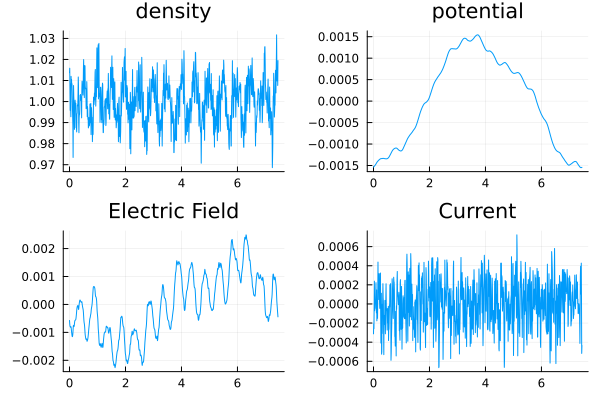

In [37]:
if !remote_server 
    plt = plot(layout=(2,2))
    plot!(subplot=1,x,n, title = "density", legend = :false)
    plot!(subplot=2,x,ϕ, title = "potential", legend = :false)
    plot!(subplot=3,x,E_i, title = "Electric Field", legend = :false)
    
    plot!(subplot=4,x,S, title = "Current", legend = :false)
end

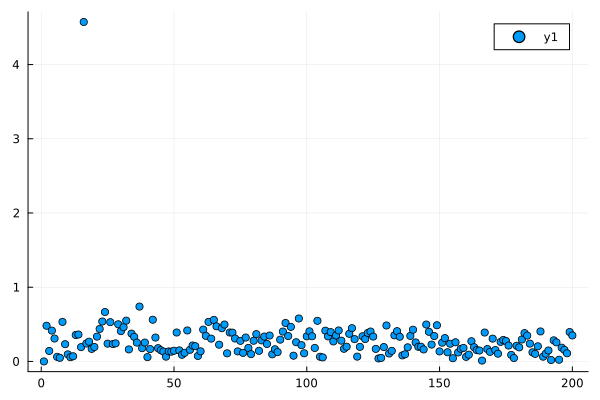

In [38]:
n_Fourier = rfft(n.-1)
freqs_space = fftshift(fftfreq(J,1/dx))
#Plots.scatter(freqs_space,abs.(fftshift(n_Fourier)))
Plots.scatter(abs.(n_Fourier)[1:200])

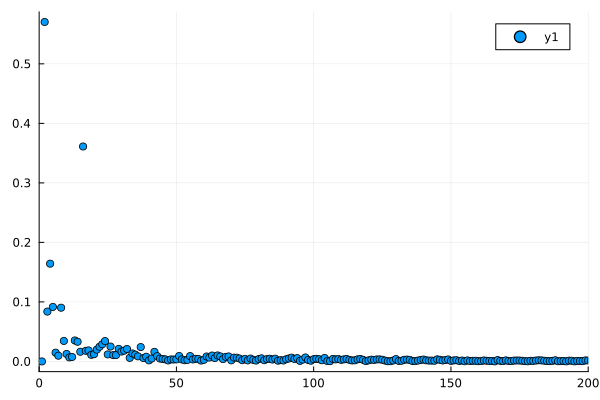

In [39]:
E_Fourier = rfft(u[2N+1:end])
Plots.scatter(abs.((E_Fourier)),xlim=(0,200))

In [40]:

n_mp = zeros(J)
#=
Tn = zeros(nthreads())
get_density_threads!(par_dis, n_mp, (par_grid, Tn), 0.5) 
=#
get_density!(par_dis, n_mp, par_grid, 0.5)

930-element Vector{Float64}:
 1.015543916411277
 1.0135770556335697
 0.9965277410378777
 1.003700954202071
 1.0054443770889123
 0.989892754951364
 1.0039613609978535
 1.011629670421219
 1.0080358127120368
 1.010720293178541
 ⋮
 1.018527848944318
 1.0276542564704683
 1.0262584888470714
 1.0128347705199576
 1.0106093886779552
 1.0197795628848663
 1.0086243570138949
 1.015419696993218
 1.0155825347163425

In [41]:
E_d = zeros(J)
get_E_direct!(E_d,-n_mp .+ 1.0, par_grid)

930-element Vector{Float64}:
 -0.0005705516866340945
 -0.0006951537262535242
 -0.0008039891560903652
 -0.0007761550802165781
 -0.0008058224066428565
 -0.0008494652358878472
 -0.0007684442554173294
 -0.0008001990363194775
 -0.0008934239750186049
 -0.0009578400865973514
  ⋮
  0.0006742802459295883
  0.0005257586181017496
  0.00030407852994331845
  9.358709515308497e-5
 -9.29808143431733e-6
 -9.434431003018436e-5
 -0.00025289983831693486
 -0.0003220337969605759
 -0.00044564007769653385

In [42]:
sum(E_d)

3.86843335142828e-16

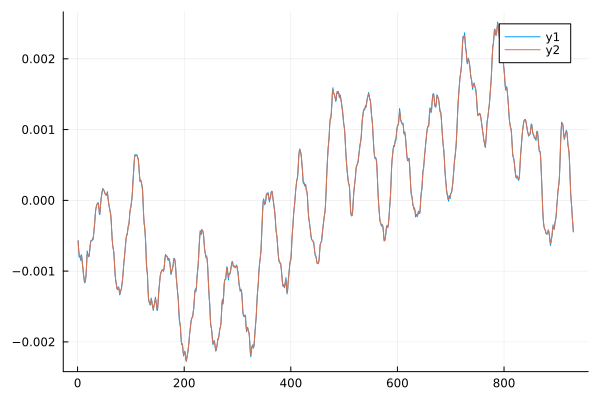

In [43]:
plot(E_d)
plot!(u[2N+1:end])

In [19]:
include("../aux_functions.jl")

get_fourier_E

In [44]:
m=16
rfft(E_d)[m]

-0.004960701716458793 + 0.36185972430199im

In [45]:
rfft(u[2N+1:end])[m]

-0.004950094091655782 + 0.36108608344952864im

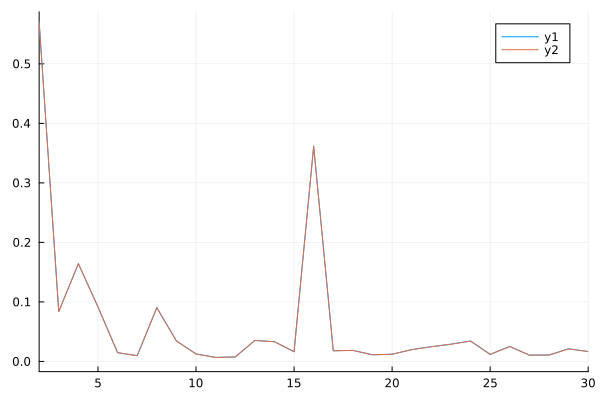

In [46]:
plot(abs.(rfft(E_d)), xlim=(2,30))
plot!(abs.(rfft(u[2N+1:end])))